### Determining individuals of European Ancestry
`Field 22006 - Genetic ethnic grouping` shows participants self-identified as “White British” according to `Field 21000_i0` and have very similar genetic ancestry based on principal component analysis of the. 
This field was based to filter individuals of European ancestry (caucasian) from the dataset.  genotypes of caucasian 

### Determining individuals of African Ancestry-
`Field 21000_i0 - Ethnic background` shows self-reported ancestry for all individuals. We have no genetic ancestry field for African individuals as it is with Caucasian. We therefore developed a genetic ancestry classification to get inviduals of African ancestry using principal component analysis and random forest to calculate posterior probabilities (Sinkala et al., 2023)) in a two-step process.


#### Step 1:
We use the African self-identified individuals and European individuals to train the Random Forest classifier.
To ensure balance in model training,  we downsampled the larger European dataset to match the number of individuals in the African dataset.

* Select the African self-reported participants as characterised by the column `ethinic_group` and sample an equal number of European(Causasian) individuals as characterised by the column `genetic_ethnic_group`
* create new dataframe including the African individuals and the sampled European individuals
* Extract the first 20 PCs as the `X` variable and the `ethnic_group` as the `y` variable (African - 1 & European - 0 
* Train the random forest classifier model and predict the posterior probability


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load your data
data = pd.read_csv('test_data.csv')

#Filter participants of African ancestry
AFR = data[(data['ethnic_group']=='African')]

#Filter participants of EUR ancestry
EUR = data[(data['genetic_ethnic_group']=='Caucasian')]

#Sample EUR ancestry participants of equal number as African ancestry
EUR_sampled = EUR.sample(n=len(AFR), random_state=42)

# add the two dataframes
AFR_EUR = pd.concat([AFR, EUR_sampled], ignore_index=True)


# Prepare features and target variable
X_train = AFR_EUR[[f'pc{i}' for i in range(1, 21)]]
y_train = (AFR_EUR['ethnic_group'] == 'African').astype(int)  # 1 for African, 0 for European

# Train Random Forest Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict probabilities for the training set
train_predictions_proba = model.predict_proba(X_train)[:, 1]

In [3]:
train_predictions_proba

array([1., 1., 1., ..., 0., 0., 0.])

In [4]:
#'African', 'Caribbean','Prefer not to answer','Any other mixed background','White and Black Caribbean',
#                         'White and Black African','Any other Black background','Other ethnic group','Do not know','Black or Black British']

#### Step 2
*  Validate with the different population groups (`'Caribbean'`, `'White and Black Caribbean'`, `'White and Black African'`, `'Any other Black background'`, `'Black or Black British'`) to assign ancestry groups 
*  Calculate the posterior probability of belonging to the African ancestry group for each individual in the validation set.
*   Exclude individuals with posterior probabilities < 0.5 from further analyses

In [5]:
# Prepare validation set (other ancestry groups)
validation_set = data[data['ethnic_group'].isin(['Caribbean', 'White and Black African', 'White and Black Caribbean', 'Black or Black British','Any other Black background'])]

# Extract features for validation
X_valid = validation_set[[f'pc{i}' for i in range(1, 21)]]

# Predict probabilities for validation set
validation_predictions_proba = model.predict_proba(X_valid)[:, 1]

# Assign posterior probabilities and create a DataFrame
validation_results = validation_set.copy()
validation_results['posterior_probability'] = validation_predictions_proba

# Filter out individuals with posterior probabilities < 0.8
high_confidence_results = validation_results[validation_results['posterior_probability'] >= 0.8]

# Output the results
print(high_confidence_results[['IID', 'ethnic_group', 'posterior_probability']])

            IID               ethnic_group  posterior_probability
26      1020999                  Caribbean                   1.00
66      1049551                  Caribbean                   1.00
149     1114147  White and Black Caribbean                   0.91
199     1159296                  Caribbean                   1.00
251     1200110                  Caribbean                   1.00
...         ...                        ...                    ...
338678  5994319                  Caribbean                   1.00
338723  5996873    White and Black African                   0.96
338749  5999225                  Caribbean                   1.00
338810  6004672                  Caribbean                   1.00
338811  6004810                  Caribbean                   0.99

[4247 rows x 3 columns]


In [6]:
# Finding individuals with posterior probabilities < 0.5
low_confidence_results = validation_results[validation_results['posterior_probability'] <= 0.8]

# Output the results
print(low_confidence_results[['IID', 'ethnic_group', 'posterior_probability']])

            IID               ethnic_group  posterior_probability
3502    4018383                  Caribbean                   0.76
5149    5366910    White and Black African                   0.68
5215    5432057    White and Black African                   0.00
5881    5975446  White and Black Caribbean                   0.00
8528    3172229    White and Black African                   0.67
...         ...                        ...                    ...
322310  4664960                  Caribbean                   0.76
323067  4726966  White and Black Caribbean                   0.24
325185  4897272  White and Black Caribbean                   0.77
325956  4961624  White and Black Caribbean                   0.70
329289  5232845                  Caribbean                   0.80

[98 rows x 3 columns]


In [7]:
high_confidence_results

,IID,age,sex,genetic_sex,kinship,ethnic_group,genetic_ethnic_group,ever-smoked,pc1,pc2,...,pc16,pc17,pc18,pc19,pc20,t2d_cc,age_sex,age_squared,age_squared_sex,posterior_probability
26,1020999,62,0,0,No kinship found,Caribbean,NaN,0.0,408.095,77.3714,...,-0.689920,-4.458750,-1.724830,-0.597713,0.585103,1,0,3844,0,1.00
66,1049551,56,0,0,No kinship found,Caribbean,NaN,0.0,243.783,52.0376,...,-1.000790,0.885154,0.868953,1.758780,-0.000080,1,0,3136,0,1.00
149,1114147,45,0,0,No kinship found,White and Black Caribbean,NaN,1.0,91.491,-130.0690,...,-0.200939,-3.196740,0.689867,5.256880,-0.557061,1,0,2025,0,0.91
199,1159296,65,1,1,No kinship found,Caribbean,NaN,0.0,397.774,76.9044,...,-0.668704,0.764869,1.050790,1.965200,0.164708,1,65,4225,4225,1.00
251,1200110,61,1,1,No kinship found,Caribbean,NaN,0.0,334.157,69.5199,...,-1.781490,-0.513656,-1.466600,-1.940190,-1.819530,1,61,3721,3721,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338678,5994319,43,0,0,No kinship found,Caribbean,NaN,0.0,310.311,60.0054,...,-1.331020,1.760650,0.112953,-1.104830,-0.400455,0,0,1849,0,1.00
338723,5996873,52,0,0,No kinship found,White and Black African,NaN,1.0,192.902,43.1257,...,-3.752910,-1.142860,-2.974740,0.213021,-0.051079,0,0,2704,0,0.96
338749,5999225,53,0,0,No kinship found,Caribbean,NaN,NaN,381.926,71.6594,...,-4.607390,-1.963980,1.915270,-2.018310,-1.059400,0,0,2809,0,1.00
338810,6004672,55,1,1,No kinship found,Caribbean,NaN,1.0,385.880,70.4116,...,-1.921330,-1.031990,1.673690,-1.684350,0.715869,0,55,3025,3025,1.00


In [8]:
# combining all African Ancestry individuals 
df_AFR = pd.concat([AFR, high_confidence_results], ignore_index=False)

In [9]:
df_AFR.head()

,IID,age,sex,genetic_sex,kinship,ethnic_group,genetic_ethnic_group,ever-smoked,pc1,pc2,...,pc16,pc17,pc18,pc19,pc20,t2d_cc,age_sex,age_squared,age_squared_sex,posterior_probability
7,1008257,49,0,0,No kinship found,African,NaN,1.0,406.375,77.6622,...,-5.36427,-1.347380,-0.498836,-3.991670,2.047940,1,0,2401,0,NaN
28,1021827,65,0,0,No kinship found,African,NaN,0.0,401.949,75.8676,...,-4.37013,-3.157810,0.626465,2.112770,-0.645965,1,0,4225,0,NaN
73,1054191,58,1,1,No kinship found,African,NaN,0.0,401.730,73.9368,...,11.03770,0.148345,0.669079,0.667130,0.000467,1,58,3364,3364,NaN
89,1071021,40,1,1,No kinship found,African,NaN,0.0,407.796,75.7367,...,-4.31778,-1.661870,-1.412170,0.348797,1.786330,1,40,1600,1600,NaN
200,1160507,56,1,1,No kinship found,African,NaN,0.0,412.094,81.1900,...,-4.60058,-1.262460,-2.548510,0.467049,0.183206,1,56,3136,3136,NaN


In [10]:
df_AFR.shape[0]

7247

In [11]:
# combining all European individuals and African individuals
df_All = pd.concat([df_AFR, EUR], ignore_index=False)

In [12]:
df_All.shape

(283579, 33)

In [13]:
df_All.head()

,IID,age,sex,genetic_sex,kinship,ethnic_group,genetic_ethnic_group,ever-smoked,pc1,pc2,...,pc16,pc17,pc18,pc19,pc20,t2d_cc,age_sex,age_squared,age_squared_sex,posterior_probability
7,1008257,49,0,0,No kinship found,African,NaN,1.0,406.375,77.6622,...,-5.36427,-1.347380,-0.498836,-3.991670,2.047940,1,0,2401,0,NaN
28,1021827,65,0,0,No kinship found,African,NaN,0.0,401.949,75.8676,...,-4.37013,-3.157810,0.626465,2.112770,-0.645965,1,0,4225,0,NaN
73,1054191,58,1,1,No kinship found,African,NaN,0.0,401.730,73.9368,...,11.03770,0.148345,0.669079,0.667130,0.000467,1,58,3364,3364,NaN
89,1071021,40,1,1,No kinship found,African,NaN,0.0,407.796,75.7367,...,-4.31778,-1.661870,-1.412170,0.348797,1.786330,1,40,1600,1600,NaN
200,1160507,56,1,1,No kinship found,African,NaN,0.0,412.094,81.1900,...,-4.60058,-1.262460,-2.548510,0.467049,0.183206,1,56,3136,3136,NaN


In [14]:
## map genetic ethnicity 
EUR.loc[:,"pop"] = "European"

/tmp/ipykernel_24269/2055280651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EUR.loc[:,"pop"] = "European"


In [15]:
df_AFR.loc[:, "pop"] = "African"

In [16]:
df_All = pd.concat([df_AFR, EUR], ignore_index=False)

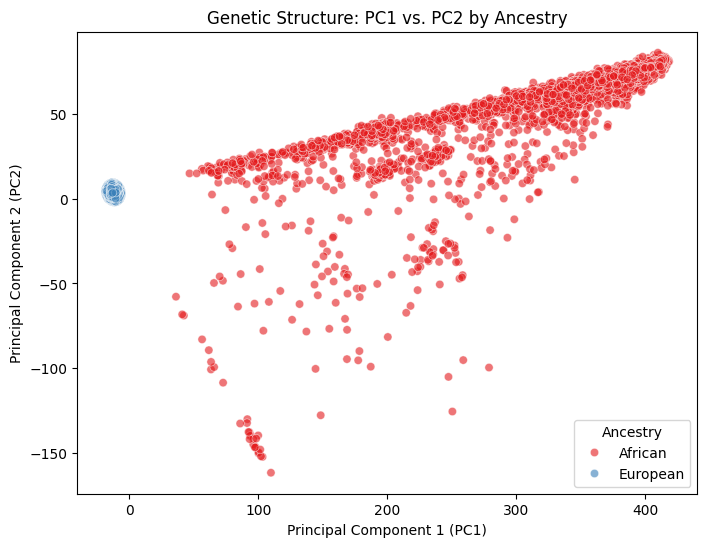

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of PC1 vs. PC2, colored by ancestry
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_All["pc1"], y=df_All["pc2"], hue=df_All["pop"], alpha=0.6, palette="Set1")
plt.title("Genetic Structure: PC1 vs. PC2 by Ancestry")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend(title="Ancestry", loc="lower right")
plt.show()

### References
1. Sinkala, M., Elsheikh, S. S. M., Mbiyavanga, M., Cullinan, J., & Mulder, N. J. (2023). A genome-wide association study identifies distinct variants associated with pulmonary function among European and African ancestries from the UK Biobank. Communications Biology, 6(1), 1–11. https://doi.org/10.1038/s42003-023-04443-8

In [ ]:
df